In [2]:
import numpy as np
import glob
import os
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [4]:
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"])  # GPU 디바이스 번호에 맞게 수정
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
사용 중인 디바이스 수: 3


In [6]:
# 메모리 매핑을 사용하여 데이터 로드
images = np.load('f_youtube_dataset_images.npy', mmap_mode='r')
landmarks = np.load('f_youtube_dataset_landmarks.npy', mmap_mode='r')

# limit개 샘플로 제한
limit = 150000
images = images[:limit]
landmarks = landmarks[:limit]

# 서브셋의 형태 출력
print(f'제한된 이미지 형태: {images.shape}')         # 예: (limit, 224, 224, 3)
print(f'제한된 키포인트 형태: {landmarks.shape}')   # 예: (limit, 68, 2)

제한된 이미지 형태: (150000, 224, 224, 3)
제한된 키포인트 형태: (150000, 68, 2)


### Only eye

데이터셋 셔플, 배치, 프리페치 설정 완료.
배치 이미지 형태: (48, 224, 224, 3)
배치 키포인트 형태: (48, 24)


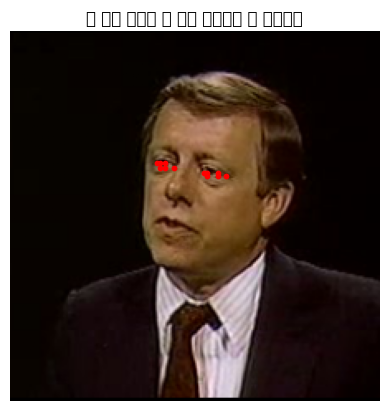

In [8]:
# 양쪽 눈 랜드마크 인덱스 정의 (0-based)
right_eye_indices = np.arange(36, 42)  # 36, 37, 38, 39, 40, 41
left_eye_indices = np.arange(42, 48)   # 42, 43, 44, 45, 46, 47
eye_indices = np.concatenate((right_eye_indices, left_eye_indices))  # 36-41, 42-47

# 제너레이터 함수 정의 (눈 랜드마크만 반환)
def data_generator(images, landmarks):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)  # 샘플 섞기

    for idx in indices:
        image = images[idx].astype(np.float32) / 255.0  # 이미지 정규화 [0,1]
        landmark = landmarks[idx].astype(np.float32) / 224.0  # 키포인트 정규화 [0,1]
        landmark = landmark.reshape(-1, 2)  # (68, 2)
        eye_landmarks = landmark[eye_indices].reshape(-1)  # (12, 2) -> (24,)
        yield image, eye_landmarks

def generator():
    return data_generator(images, landmarks)

# TensorFlow 데이터셋 생성 (눈 랜드마크만 반환)
output_signature = (
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(24,), dtype=tf.float32)  # 12 keypoints * 2 (x, y) = 24
)

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
)

# 데이터셋 셔플, 배치, 프리페치 설정
batch_size_per_replica = 16  # 각 GPU당 배치 사이즈
num_replicas = 3  # GPU 수
batch_size = batch_size_per_replica * num_replicas  # 총 배치 사이즈: 32

dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print('데이터셋 셔플, 배치, 프리페치 설정 완료.')

# 데이터셋 형태 확인 및 시각화
for batch_images, batch_landmarks in dataset.take(1):
    print('배치 이미지 형태:', batch_images.shape)         # (32, 224, 224, 3)
    print('배치 키포인트 형태:', batch_landmarks.shape)   # (32, 24)
    
    # 시각화 예시 (눈 랜드마크만)
    image = batch_images[0].numpy()
    landmarks_plot = batch_landmarks[0].numpy() * 224.0  # 정규화된 키포인트를 원래 크기로 복원
    
    plt.imshow(image)
    plt.scatter(landmarks_plot[::2], landmarks_plot[1::2], c='r', s=10)
    plt.title('첫 번째 배치의 첫 번째 이미지와 눈 랜드마크')
    plt.axis('off')
    plt.show()

In [10]:
# 학습용과 검증용 데이터셋 분리
total_samples = 150000
train_ratio = 0.8
val_ratio = 0.2

train_size = int(train_ratio * total_samples)  
val_size = total_samples - train_size        

train_ds = dataset.take(train_size // batch_size)  
val_ds = dataset.skip(train_size // batch_size).take(val_size // batch_size)  

print(f'학습 데이터셋 배치 수: {train_size // batch_size}')  
print(f'검증 데이터셋 배치 수: {val_size // batch_size}')  


학습 데이터셋 배치 수: 2500
검증 데이터셋 배치 수: 625


In [7]:
# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    def create_model(input_shape=(224, 224, 3), num_keypoints=24):
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        base_model.trainable = True

        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1024, activation='relu')(x)
        outputs = layers.Dense(num_keypoints)(x)  # 회귀 문제이므로 활성화 함수 없음

        model = models.Model(inputs=base_model.input, outputs=outputs)
        return model

    # 모델 정의
    model = create_model()

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mean_squared_error',
                  metrics=['mae'])

    # 모델 요약
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
사용 중인 디바이스 수: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0

In [9]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, CSVLogger
import time

def lr_scheduler(epoch):
    if epoch < 50:
        return 0.001  # 첫 50 에포크 동안 학습률은 0.001
    else:
        return 0.0001  # 에포크 51부터 100까지 학습률은 0.0001

# 에포크 시간 측정을 위한 콜백 클래스 정의
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
        
# 콜백 설정
checkpoint = ModelCheckpoint('y_eye_v2_adam.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
time_callback = TimeHistory()
csv_logger = CSVLogger('y_eye_training_log.csv', append=True)

# **모델 훈련**

EPOCHS = 100

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, lr_scheduler_callback, time_callback, csv_logger]
)

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 160 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 160 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-11 12:10:55.839282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-11 12:10:55.871737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-11 12:10:59.291834: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8450d63a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-11 12:10:59.291878: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-11 12:10:59.291884: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-11 12:10:59.291889: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-11-11 12:10:59.299776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH

   2500/Unknown - 308s 101ms/step - loss: 0.0017 - mae: 0.0170

2024-11-11 12:15:23.604740: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12639102317344436646
2024-11-11 12:15:23.604817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11906004006442037898
2024-11-11 12:15:23.604827: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16551799896964208174
2024-11-11 12:15:23.604840: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8809275626071402666
2024-11-11 12:15:23.604848: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13901456328369611285
2024-11-11 12:15:23.604916: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8261975416665695953
2024-11-11 12:15:23.604933: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv


Epoch 1: val_loss improved from inf to 0.00943, saving model to y_eye_v2_adam.h5


2024-11-11 12:16:37.563349: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16726644361433744614
2024-11-11 12:16:37.563424: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16551799896964208174
2024-11-11 12:16:37.563434: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3047581284230436630
2024-11-11 12:16:37.563445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9091488961343269042
2024-11-11 12:16:37.563453: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7385735165940959554
2024-11-11 12:16:37.563460: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6281491483364867218
2024-11-11 12:16:37.563468: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

2500/2500 [==============================] - 383s 131ms/step - loss: 0.0017 - mae: 0.0170 - val_loss: 0.0094 - val_mae: 0.0951 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - ETA: 0s - loss: 8.9799e-05 - mae: 0.0074
Epoch 2: val_loss improved from 0.00943 to 0.00424, saving model to y_eye_v2_adam.h5
2500/2500 [==============================] - 308s 121ms/step - loss: 8.9799e-05 - mae: 0.0074 - val_loss: 0.0042 - val_mae: 0.0634 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - ETA: 0s - loss: 7.3504e-05 - mae: 0.0067
Epoch 3: val_loss improved from 0.00424 to 0.00386, saving model to y_eye_v2_adam.h5
2500/2500 [==============================] - 296s 117ms/step - loss: 7.3504e-05 - mae: 0.0067 - val_loss: 0.0039 - val_mae: 0.0603 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - ETA: 0s - loss: 6.6510e-05 - mae: 0.0063
Epoch 4: val_loss improved from 0.00386 to 0.00279, saving model to y_eye_v2_adam.h5
2500/2500 [============

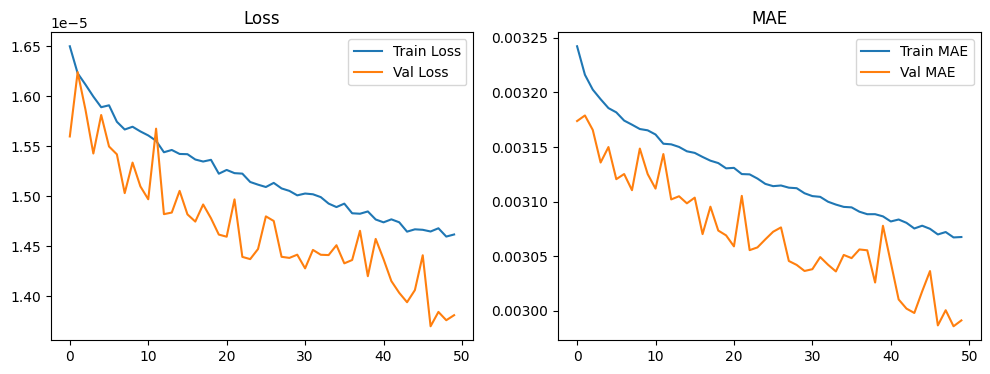

In [11]:
import matplotlib.pyplot as plt

# 훈련 손실 및 MAE 시각화
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][50:], label='Train Loss')
plt.plot(history.history['val_loss'][50:], label='Val Loss')
plt.legend()
plt.title('Loss')

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'][50:], label='Train MAE')
plt.plot(history.history['val_mae'][50:], label='Val MAE')
plt.legend()
plt.title('MAE')

plt.show()

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import time
from tensorflow.keras import layers, models

# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    # 3. 모델 로드
    model = tf.keras.models.load_model('model_h5/y_eye_v2_adam.h5')
    
    # 4. 모델 컴파일
    # 옵티마이저, 손실 함수, 평가 지표를 정의합니다.
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    
    # 5. 콜백 설정
    checkpoint = ModelCheckpoint('y_eye_v2_rmsprop.h5', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1)
    csv_logger = CSVLogger('y_eye_v2_rmsprop.csv', append=True)
    
    # 6. 배치 사이즈 설정
    per_replica_batch_size = 16
    GLOBAL_BATCH_SIZE = per_replica_batch_size * strategy.num_replicas_in_sync
    
    # 7. 모델 훈련
    EPOCHS = 200
    
    history = model.fit(
        train_ds, 
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[checkpoint, reduce_lr, csv_logger]
    )

Epoch 1/200
INFO:tensorflow:Collective all_reduce tensors: 160 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 160 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-22 03:18:01.131570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-22 03:18:01.147494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-22 03:18:01.168285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-22 03:18:04.614951: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2cbb37bb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-22 03:18:04.614996: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-22 03:18:04.615003: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-22 03:18:04.615008: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-11-22 03:18:04.623766: I ten

   2500/Unknown - 331s 111ms/step - loss: 3.2096e-05 - mae: 0.0046

2024-11-22 03:22:50.079446: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11856398595749347529
2024-11-22 03:22:50.081051: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15575784573399795245
2024-11-22 03:22:50.081066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8557015547931923114
2024-11-22 03:22:50.081117: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17681870889513315942
2024-11-22 03:22:50.081134: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10099322990737960778
2024-11-22 03:22:50.081149: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6924267994466566179
2024-11-22 03:22:50.081187: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv


Epoch 1: val_loss improved from inf to 0.00002, saving model to y_eye_v2_rmsprop.h5


2024-11-22 03:24:30.921892: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8497045821743702082
2024-11-22 03:24:30.921948: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5028817296820701610
2024-11-22 03:24:30.921961: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3744439586049936205
2024-11-22 03:24:30.922003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7253308354576580885
2024-11-22 03:24:30.922011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4050845692011647865
2024-11-22 03:24:30.922024: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18220530706412368821
2024-11-22 03:24:30.922031: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

2500/2500 [==============================] - 433s 152ms/step - loss: 3.2096e-05 - mae: 0.0046 - val_loss: 2.0249e-05 - val_mae: 0.0036 - lr: 0.0010
Epoch 2/200
2500/2500 [==============================] - ETA: 0s - loss: 2.8942e-05 - mae: 0.0043
Epoch 2: val_loss did not improve from 0.00002
2500/2500 [==============================] - 370s 148ms/step - loss: 2.8942e-05 - mae: 0.0043 - val_loss: 2.0774e-05 - val_mae: 0.0036 - lr: 0.0010
Epoch 3/200
2500/2500 [==============================] - ETA: 0s - loss: 2.7079e-05 - mae: 0.0042
Epoch 3: val_loss did not improve from 0.00002
2500/2500 [==============================] - 372s 149ms/step - loss: 2.7079e-05 - mae: 0.0042 - val_loss: 2.9492e-05 - val_mae: 0.0044 - lr: 0.0010
Epoch 4/200
2500/2500 [==============================] - ETA: 0s - loss: 2.5699e-05 - mae: 0.0040
Epoch 4: val_loss did not improve from 0.00002
2500/2500 [==============================] - 369s 148ms/step - loss: 2.5699e-05 - mae: 0.0040 - val_loss: 2.2545e-05 - va